In [1]:
# imports
import re
import pandas as pd
import scipy as sp
import numpy as np
import scipy.sparse
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

In [2]:
# import data
tweets = pd.read_csv('data/training/tweets.tsv', sep='\t', header=None,
                     names=['tweet_id', 'tweet'])
classes = pd.read_csv('data/training/class.tsv', sep='\t', header=0)

In [3]:
# 1. Preprocessing
# there are more classses (n=17,385) than tweets(n=17,120)
# balance the classes by left joining the classes and tweets by var 0 and tweet_id

data = pd.merge(tweets, classes, how='left')

# 1.1. Remove '@USER' and any proceeding '_' from tweet variable in dataframe
data = data.replace(r'@\w+', '', regex=True)

# remove any emoji from the tweet
data = data.replace(r'[^\w\s]', '', regex=True)

# are there duplicates?
np.sum(data.duplicated()) 
# NO!
# are there missing values?
data.isnull().sum()
# no missing values!

# convert label to binary
data = data.replace(['NoADE', 'ADE'], [0, 1])

In [4]:
# 2. split data into training and test sets
# use stratified sampling to balance the classes
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=691)
X = data['tweet'].to_numpy()
y = data['label'].to_numpy()

for train_index, test_index in strat_split.split(X, y):
    print(f"Train index: {train_index}", f"Test index: {test_index}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


Train index: [ 3360  9091  6988 ...   910 12559   444] Test index: [ 5122  1796   298 ...  1025  2309 14625]


In [5]:
# 3. EDA
# from pandas_profiling import ProfileReport
# profile_train = pandas_profiling.ProfileReport(train, title="Pandas Profiling Report (Train)")
# profile_train.to_file("DSCI691-GRP-PICKLE_RICK/Task_1/subtask_1a/profile_train.html")
# check for class imbalance
data.groupby('label').size()

label
0    15909
1     1211
dtype: int64

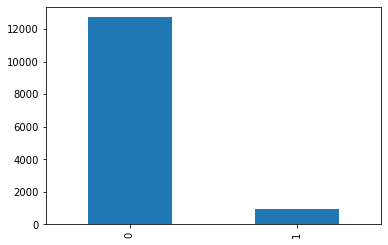

In [6]:
# visualize the distribution of y_train data
import matplotlib.pyplot as plt
ys = pd.Series(y_train)
ys.value_counts().plot(kind='bar')
plt.show()

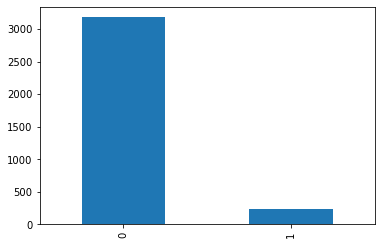

In [7]:
# test data
ys2 = pd.Series(y_test)
ys2.value_counts().plot(kind='bar')
plt.show()

In [8]:
# Notes:
# There is a class imbalance in the outcome variable "class"
# Only 7.2% of the tweets are labeled as "NoADE"
# see report for more details
# suggestion from jake: keep data as is
###################################################################################################
# 4. text representation
# convert tweets to matrix of word counts and remove stop words
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(stop_words='english')

In [9]:
# normalise count matrix to decrease the effect of word frequencies
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()

# vectorize and transform train and test data
train_transformed = tfidf.fit_transform(countvec.fit_transform(X_train))
test_transformed = tfidf.transform(countvec.transform(X_test))

In [10]:
###################################################################################################
# LOGISTIC REGRESSION
###################################################################################################
# classification using logistic regression
# course notes uses the 'liblinear' solver however sklearn uses the 'lbfgs' solver as default
log_reg = LogisticRegression(solver='lbfgs', random_state=691, class_weight='balanced')

# fit
log_reg.fit(train_transformed, y_train)
y_pred = log_reg.predict(test_transformed)

In [11]:
# print results
print(f"Logistic Regression:")
print(f"AUC: {roc_auc_score(y_test, y_pred)}")  #0.797
print(f"Precision: {precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)[0]:.2f}") # 0.37
print(f"Recall: {precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)[1]:.2f}") # 0.68
print(f"F1 Score: {precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)[2]:.2f}") # 0.48

Logistic Regression:
AUC: 0.8005490595342605
Precision: 0.38
Recall: 0.69
F1 Score: 0.49


In [12]:
# confusion matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)

In [13]:
# SVM WITH TF-IDF FEATURES
###################################################################################################
# standard SVM classifier with TF-IDF features
# linear kernel
sv_m = SVC(kernel='linear', class_weight='balanced', random_state=691)
# fit
sv_m.fit(train_transformed, y_train)
y_pred_sv = sv_m.predict(test_transformed)

In [14]:
# print results
print(f"SVM:")
print(f"AUC: {roc_auc_score(y_test, y_pred_sv)}")
print(f"Precision: {precision_recall_fscore_support(y_test, y_pred_sv, average='binary', pos_label=1)[0]:.2f}")
print(f"Recall: {precision_recall_fscore_support(y_test, y_pred_sv, average='binary', pos_label=1)[1]:.2f}")
print(f"F1 Score: {precision_recall_fscore_support(y_test, y_pred_sv, average='binary', pos_label=1)[2]:.2f}")

SVM:
AUC: 0.7523699944418761
Precision: 0.44
Recall: 0.56
F1 Score: 0.49


In [15]:
# roBERTa model
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
text = train_transformed
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).